Datos obtenidos correctamente
Mejores parámetros: {'C': 0.1, 'gamma': 'auto', 'kernel': 'poly'}
MAE: 0.5846285700686079
RMSE: 0.8488831598111529
MAPE: 32.73503503412205%
Accuracy: 67.26496496587795%
Órdenes predichas para 2024-07-01: 0.861799910166734


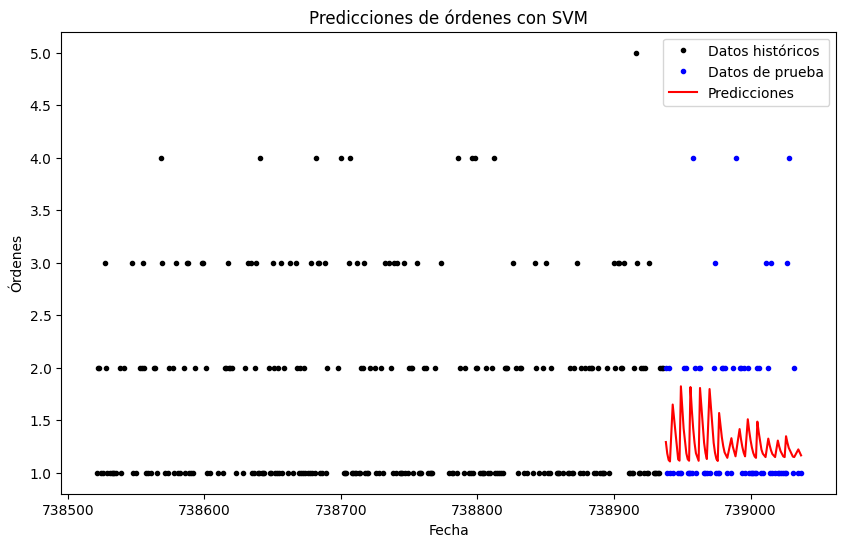

In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV

# URL de la API
api_url = "http://localhost:3000/api/dashboard/orders-by-date-range?start=2023-01-01&end=2024-06-01"

# Hacer la solicitud GET a la API
response = requests.get(api_url)

# Intentar decodificar la respuesta como JSON
try:
    data = response.json()
    print("Datos obtenidos correctamente")
except json.JSONDecodeError as e:
    print(f"Error decodificando JSON: {e}")
    data = None

# Convertir los datos a un DataFrame
df = pd.DataFrame(data['data'])
df['entry_date'] = pd.to_datetime(df['entry_date'])

# Eliminar la información de zona horaria
df['entry_date'] = df['entry_date'].dt.tz_localize(None)

df = df.drop_duplicates()
df = df.rename(columns={"entry_date": "ds", "total_orders": "y"})

# Agregar características adicionales
df['day_of_week'] = df['ds'].dt.dayofweek
df['month'] = df['ds'].dt.month
df['quarter'] = df['ds'].dt.quarter
df['day_of_year'] = df['ds'].dt.dayofyear
df['week_of_year'] = df['ds'].dt.isocalendar().week

# Preparar los datos para el entrenamiento
df['ds'] = pd.to_datetime(df['ds']).map(pd.Timestamp.toordinal)
X = df[['ds', 'day_of_week', 'month', 'quarter', 'day_of_year', 'week_of_year']]
y = df['y']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ajuste de hiperparámetros usando GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Obtener los mejores parámetros
best_params = grid_search.best_params_
print(f"Mejores parámetros: {best_params}")

# Entrenar el modelo con los mejores parámetros
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Realizar predicciones
y_pred = best_model.predict(X_test_scaled)

# Evaluar el modelo
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
accuracy = 100 - mape

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}%")
print(f"Accuracy: {accuracy}%")

# Predicción para una fecha específica
specific_date = '2024-07-01'
specific_date_ordinal = pd.to_datetime(specific_date).toordinal()
specific_features = pd.DataFrame({
    'ds': [specific_date_ordinal],
    'day_of_week': [pd.to_datetime(specific_date).dayofweek],
    'month': [pd.to_datetime(specific_date).month],
    'quarter': [pd.to_datetime(specific_date).quarter],
    'day_of_year': [pd.to_datetime(specific_date).dayofyear],
    'week_of_year': [pd.to_datetime(specific_date).isocalendar()[1]]
})

specific_features_scaled = scaler.transform(specific_features)
predicted_order = best_model.predict(specific_features_scaled)

print(f"Órdenes predichas para {specific_date}: {predicted_order[0]}")

# Visualizar las predicciones
plt.figure(figsize=(10, 6))

# Graficar los datos históricos
plt.plot(X_train['ds'], y_train, 'ko', markersize=3, label='Datos históricos')
plt.plot(X_test['ds'], y_test, 'bo', markersize=3, label='Datos de prueba')
plt.plot(X_test['ds'], y_pred, 'r-', label='Predicciones')

plt.xlabel('Fecha')
plt.ylabel('Órdenes')
plt.title('Predicciones de órdenes con SVM')
plt.legend()

plt.show()

In [2]:
import joblib

# Guardar el modelo y el escalador
joblib.dump(best_model, 'svr_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


['scaler.pkl']